In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

from sklearn.datasets import load_breast_cancer
import shap
#plt.style.use('default')

shap.initjs()

Используем датасет <code>cancer</code> и случайный лес. Обучимся и посмотрим результат.

Важная особенность! Для простоты дальнейшей работы с библиотекой `SHAP` признаки `X` должны быть в виде `pd.DataFrame` с именами столбцов.

## 4. Интерпритация функции потерь

Объяснение потери модели может быть очень полезным для отладки и мониторинга модели. 

Обратите внимание, что интерпритация функции потерь модели потребует передачи меток и поддерживается только для опции `feature_dependence="independent"` в `TreeExplainer`.

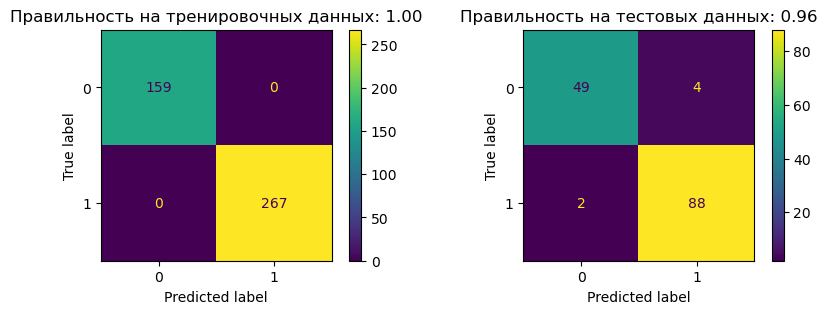

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

forest = RandomForestClassifier(n_estimators = 500, random_state = 42)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
y_train_pred = forest.predict(X_train)
y_pred_proba = forest.predict_proba(X_test)



fig, ax = plt.subplots(1,2, figsize=(10,3))
ConfusionMatrixDisplay.from_estimator(forest, X_train, y_train, ax = ax[0]);
ax[0].set_title( "Правильность на тренировочных данных: {:.2f}".format(forest.score(X_train, y_train)) )
ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, ax = ax[1]);
ax[1].set_title( "Правильность на тестовых данных: {:.2f}".format(forest.score(X_test, y_test)) );

In [3]:
# from sklearn.metrics import log_loss
# model_loss = [log_loss([y_train[i]],[forest.predict_proba(X_train)[i,1]],labels=[0,1]) 
#               for i in range(len(forest.predict_proba(X_train)))]


In [5]:
#print(model_loss[:10])
# x = range(len(forest.predict_proba(X_train)))
# plt.plot(x, logloss);

In [6]:
# explainer = shap.TreeExplainer(forest, X_train, feature_dependence="interventional", model_output="log_loss")
# expl = explainer.shap_values(X_train.iloc[:10,:], y_train.iloc[:10])[1].sum(axis=1) + np.array([explainer.expected_value(v)[1] for v in y_train])                                                                                

In [7]:
explainer = shap.explainers.Tree(forest, X_train, feature_dependence="interventional", model_output="log_loss")
shap_values = explainer.shap_values(X_train.reset_index(drop = True),y_train)
shap_values_test = explainer.shap_values(pd.concat([X_train,X_test],ignore_index = True),y)

 94%|=================== | 1065/1138 [00:14<00:00]       

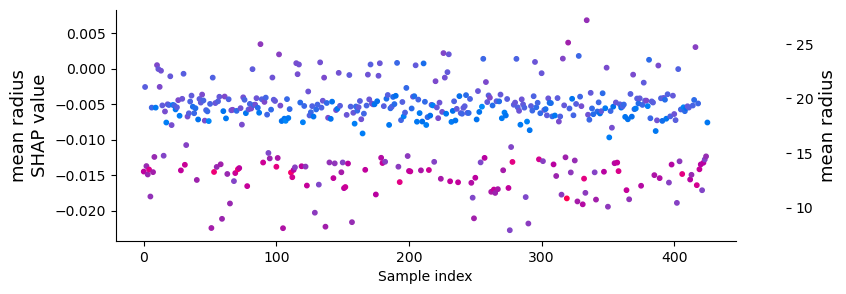

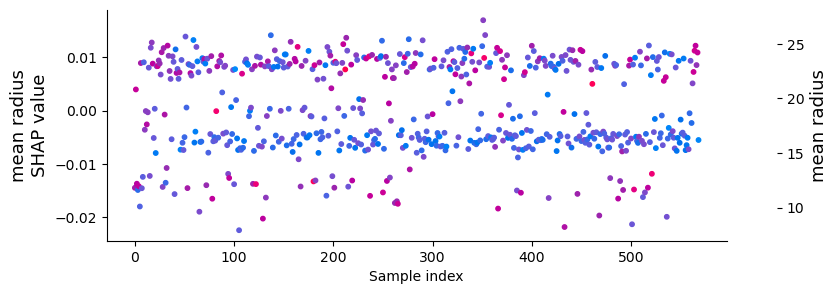

In [8]:
ind = X_train.columns.get_loc("mean radius")
shap.monitoring_plot(ind, shap_values[1], X_train)
shap.monitoring_plot(ind, shap_values_test[1], X)

In [9]:
Ser_A = X_test['mean radius']
Ser_B = X_test['mean texture']
X_test_nocorect = X_test
X_test_nocorect['mean radius']  = Ser_B
X_test_nocorect['mean texture'] = Ser_A

explainer = shap.TreeExplainer(forest, X_train, feature_dependence="interventional", model_output="log_loss")
#shap_values = explainer.shap_values(X_train.reset_index(drop = True),y_train)
shap_values_test_bad = explainer.shap_values(pd.concat([X_train,X_test_nocorect],ignore_index = True),y)

 99%|===================| 1132/1138 [00:15<00:00]        

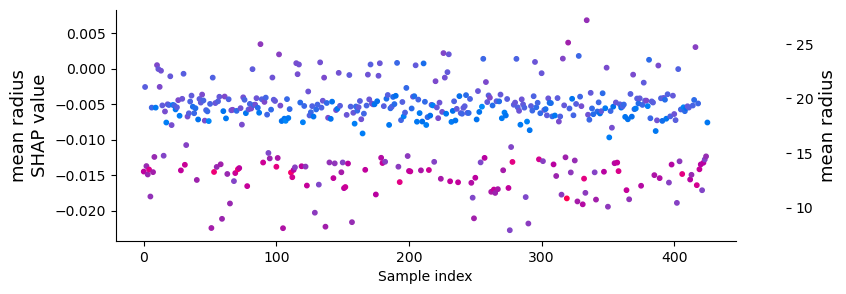

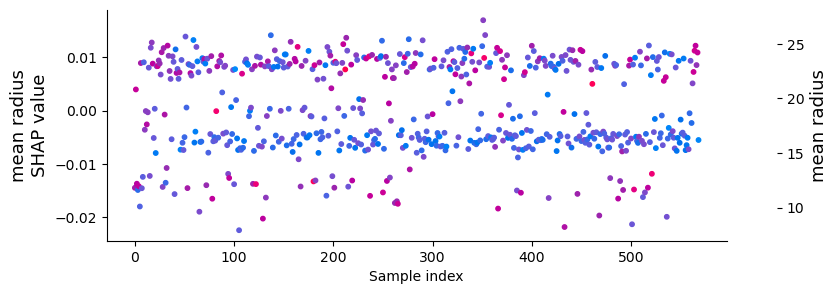

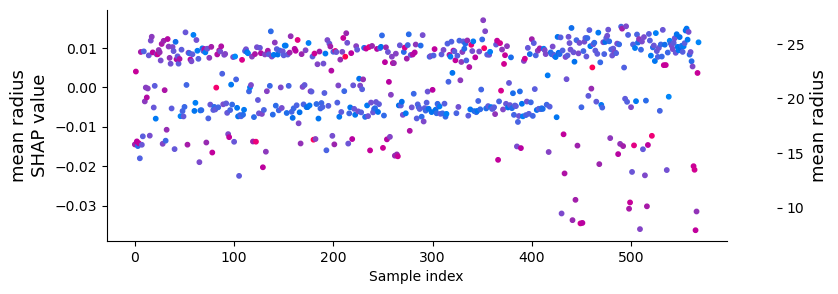

In [10]:
ind = X_train.columns.get_loc("mean radius")
shap.monitoring_plot(ind, shap_values[1], X_train)
shap.monitoring_plot(ind, shap_values_test[1], X)
shap.monitoring_plot(ind, shap_values_test_bad[1], X)

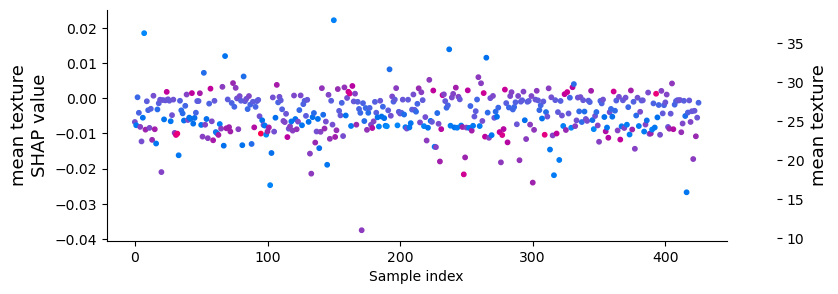

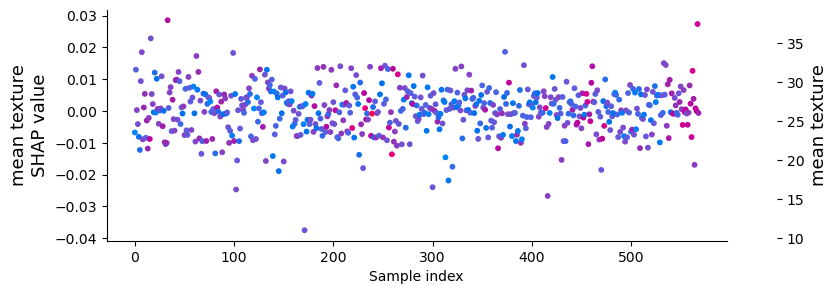

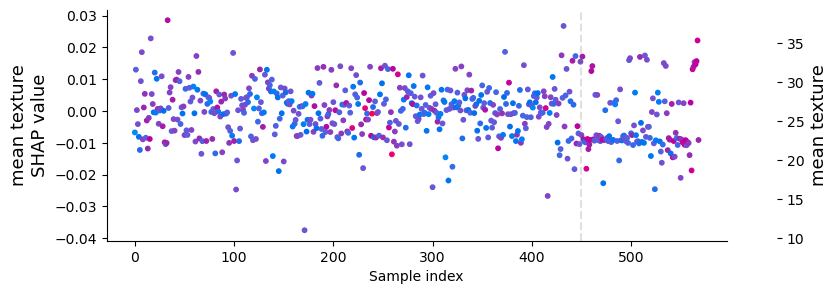

In [11]:
ind = X_train.columns.get_loc("mean texture")
shap.monitoring_plot(ind, shap_values[1], X_train)
shap.monitoring_plot(ind, shap_values_test[1], X)
shap.monitoring_plot(ind, shap_values_test_bad[1], X)

Почитать можно тут https://www.researchgate.net/figure/Monitoring-plots-reveal-problems-that-would-otherwise-be-invisible-in-a-retrospective_fig1_333077391
